# The multi-derivative DRAG pulse

In [1]:
import logging
from copy import deepcopy
import numpy as np
from numpy import pi
from qiskit.circuit import Gate
from qiskit import transpile
from qiskit.transpiler import InstructionProperties
from qiskit_utilities import (
    save_job_data,
    setup_logger,
    retrive_expdata,
    get_cr_schedule,
    iy_drag_calibration,
    get_default_cr_params,
    read_calibration_data,
    iterative_cr_pulse_calibration,
    create_echoed_cnot_schedule,
    initilize_qiskit_dynamics_backend
)
session = None  # qiskit runtime session

/local/bli/conda/test/lib/python3.12/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


Setup a logging system.

In [2]:
# Setup a logging system.
setup_logger(filename=None, level=logging.INFO, stdout=True)
logger = logging.getLogger("qiskit_utilities")

2024-01-10 23:25:03,853, MainThread 
INFO Logger initialized successfully.


Setup a simulator backend based on qiksit-dynamics and calibrate the single-qubit gates using the default calibrations from qiskit-experiment.

In [3]:
# Create a qiskit-dynamics backend with two Transmon, see fake_backend.py for detail.
# fidelity
f0 = 5.188339840468758e9
f1 = 5.079647268847252e9
# anharmonicity
a0 = -0.341931669003125e9
a1 = -0.343248404293835e9
backend = initilize_qiskit_dynamics_backend(f0, f1, a0, a1, cr_detuning=0.)

/local/bli/conda/test/lib/python3.12/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in std_dev (vectorized)
  outputs = ufunc(*inputs)


## Recursive DRAG pulse

### Hann pulse ramping time t_r=10ns

First, we reduce the ramping time to 10 ns (instead of 28.4 ns) and use a Hann pulse, which is similar to Gaussian shape. A short ramping time like this will introduce transition error on the first qubit.

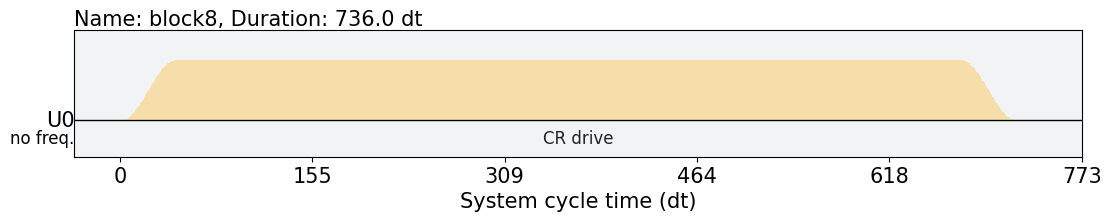

In [4]:
# Operating qubits
QUBIT_C, QUBIT_T = (0, 1)
# Compute the sampling time steps for the CR tomography experiments
if backend.name == 'DynamicsBackend':
    amp = 2 * pi * 0.04
    cr_times = np.arange(16*16, 1440*3, 32*4, dtype=int)
    duration = 720  # Used for plotting only, not tomography.
else:
    amp = get_default_cr_params(backend, QUBIT_C, QUBIT_T)[0]
    duration = backend.defaults().instruction_schedule_map.get("cx", (QUBIT_C, QUBIT_T)).duration/16 * 4
    cr_times = 16 * np.arange(16, duration + 16, duration//30, dtype=int)


## Custom shape
gate_name = "CR-Hann-tr10"
params = {
    "order": "1",  # order m for the initial pulse shape, order 1 is the Hann shape
    "t_r": 10,
    "drag_type" : False,  # Givens rotation, use "sw" for perturbation
    "duration": duration,  # only for plotting
    "amp": amp,
    "angle": 0.0,
    ## If real device, use the following
    # "Delta": (backend.properties().frequency(QUBIT_C) - backend.properties().frequency(QUBIT_T)) * 1.0e-9 * 2 * pi,
    # "a1": 2 * pi * backend.properties().qubit_property(QUBIT_C)["anharmonicity"][0] * 1.0e-9,
    ## If Dynamicsbackend, use this
    "Delta": 2 * pi * (f0 - f1) * 1.0e-9,
    "a1": 2 * pi * a0 * 1.0e-9,
    "drag_scale": [1., 1., 1.],
}
cr_params = params.copy()
ix_params = params.copy()
ix_params["amp"] = 0.0
ix_params["order"] = "2"

initial_calibration_data = {
    "cr_params": cr_params,
    "ix_params": ix_params,
    "frequency_offset": 0.,
}

get_cr_schedule((QUBIT_C, QUBIT_T), backend, cr_params=cr_params, ix_params=ix_params).draw()

2024-01-10 23:26:09,569, MainThread 
INFO 

CR calibration round 1: 
2024-01-10 23:26:10,989, MainThread 
INFO Tomography circuits have been generated.
2024-01-10 23:27:37,899, MainThread 
INFO CR tomography: 2ee401b4-095a-42b5-86bf-11daa53112fd
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '1', 't_r': 10, 'drag_type': False, 'duration': 720, 'amp': 0.25132741228718347, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': False, 'duration': 720, 'amp': 0.0, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
x_gate_ix_params: None
frequency_offset: 0.0

2024-01-10 23:27:38,111, MainThread 
INFO Job saved to data/2ee401b4-095a-42b5-86bf-11daa53112

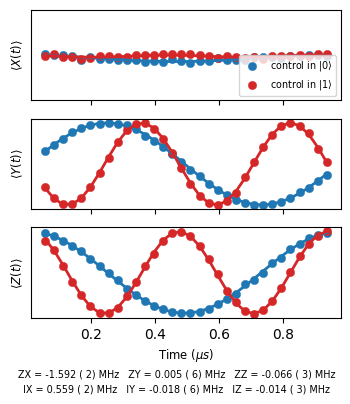

2024-01-10 23:27:38,656, MainThread 
INFO Tomography results:
{'IX': 0.5590892130603358, 'IY': -0.017869394687301803, 'IZ': -0.01434210257152218, 'ZX': -1.591611228374776, 'ZY': 0.004851998754462447, 'ZZ': -0.06575514369626596}

2024-01-10 23:27:38,657, MainThread 
INFO Remaining dominant error: IX: 0.5590892130603358 MHz

2024-01-10 23:27:41,491, MainThread 
INFO Tomography circuits have been generated.
2024-01-10 23:29:01,100, MainThread 
INFO CR tomography: 32aa3b64-5e01-4423-a35e-a9b47ff5e57e
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '1', 't_r': 10, 'drag_type': False, 'duration': 720, 'amp': 0.25132741228718347, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': False, 'duration': 7

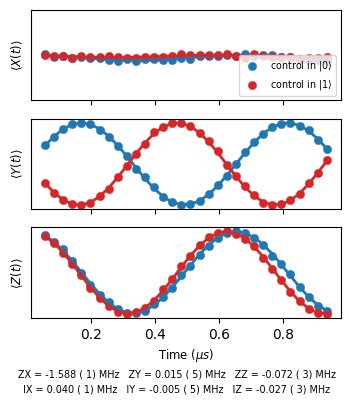

2024-01-10 23:29:01,770, MainThread 
INFO {'IX': 0.0396404813640778, 'IY': -0.005099696254723693, 'IZ': -0.027139539377573834, 'ZX': -1.5882481329863563, 'ZY': 0.014793263969546198, 'ZZ': -0.07241991901190009}
2024-01-10 23:29:01,771, MainThread 
INFO 

CR calibration round 2: 
2024-01-10 23:29:03,446, MainThread 
INFO Tomography circuits have been generated.
2024-01-10 23:30:21,616, MainThread 
INFO CR tomography: 967e9eab-2b12-4392-855e-6dadcc2af66c
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '1', 't_r': 10, 'drag_type': False, 'duration': 720, 'amp': 0.25132741228718347, 'angle': -0.003048472917114396, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': False, 'duration': 720, 'amp': -0.00349513403469

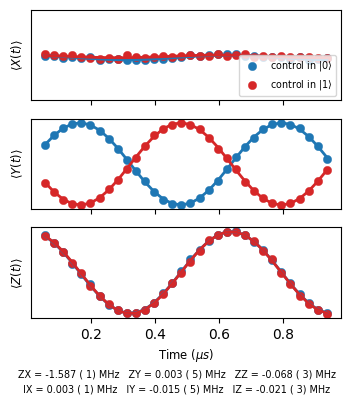

2024-01-10 23:30:22,294, MainThread 
INFO Tomography results:
{'IX': 0.0030701855397994382, 'IY': -0.014908285142516114, 'IZ': -0.020754442334756918, 'ZX': -1.5868780719925453, 'ZY': 0.003296005037237549, 'ZZ': -0.06792484684087163}

2024-01-10 23:30:22,295, MainThread 
INFO Remaining dominant error: IY: 0.014908285142516114 MHz

2024-01-10 23:30:22,295, MainThread 
INFO Successfully calibrated.
2024-01-10 23:30:22,296, MainThread 
INFO Frequency offset is updated to -20754.442334756917 Hz


In [5]:
iterative_cr_pulse_calibration(
    (QUBIT_C, QUBIT_T),
    backend,
    initial_calibration_data=initial_calibration_data,
    cr_times=cr_times,
    session=session,
    gate_name=gate_name,
    verbose=True,
    restart=True,  # fresh start
    max_repeat=3,
    shots=2048,
    mode="CR",
    )

2024-01-10 23:31:02,409, MainThread 
INFO Quantum process tomography job: 6e8d8d9a-de47-42f1-8eab-c760dc5f7cfd
backend: DynamicsBackend
qubits: (0, 1)
shots: 8096

2024-01-10 23:31:02,671, MainThread 
INFO Job saved to data/6e8d8d9a-de47-42f1-8eab-c760dc5f7cfd



(<Figure size 800x600 with 2 Axes>,
 <Axes3D: title={'center': 'Process Matrix'}>)

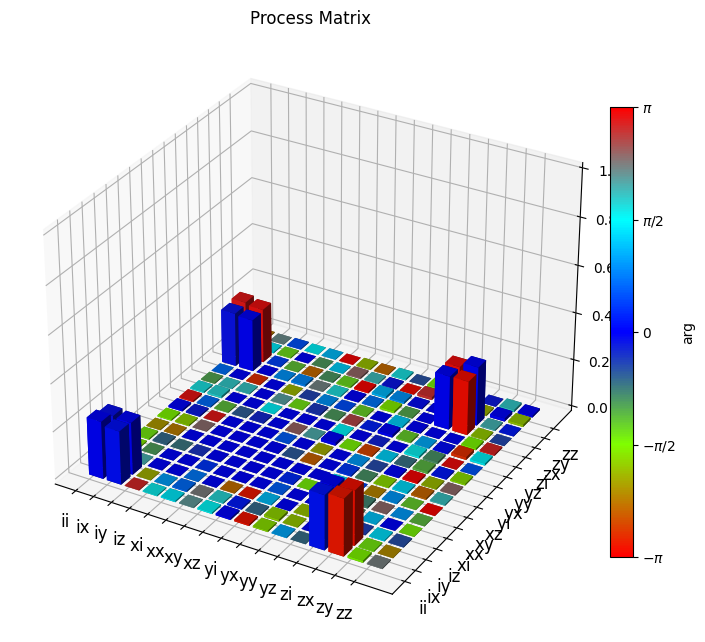

In [6]:
from qiskit_experiments.library import ProcessTomography
calibration_data = read_calibration_data(backend, gate_name, (QUBIT_C, QUBIT_T))

custom_cnot_sched = create_echoed_cnot_schedule(backend, (QUBIT_C, QUBIT_T), calibration_data, reverse_direction=False)

# Show the custom CNOT schedule.
custom_cnot_sched.draw()

custom_cnot = Gate("custom_cnot", 2, [])
backend_tmp = deepcopy(backend)
backend_tmp.target.add_instruction(
    custom_cnot,
    {(QUBIT_C, QUBIT_T): InstructionProperties(calibration=custom_cnot_sched)},
    name="custom_cnot",
)
qptexp = ProcessTomography(custom_cnot, physical_qubits=[QUBIT_C, QUBIT_T])

try:
    basis_gates = backend.configuration().basis_gates
except AttributeError:
    basis_gates = ["measure", "sx", "x", "rz"]
transpiled_circ_list = transpile(
    qptexp._transpiled_circuits(),
    backend=backend_tmp,
    basis_gates = basis_gates + ["custom_cnot"],
    optimization_level= 1,  # Turn off optimization to keep the custom pulse
    )

shots = 8096
if session is not None:
    qpt_job = session.run(
        "circuit-runner",
        inputs={
            "circuits": transpiled_circ_list,
            "skip_transpilation": True,
            "shots": shots,
        },
    )
else:
    qpt_job = backend.run(transpiled_circ_list, shots=shots)

parameters = {
    "backend": backend.name,
    "qubits": (QUBIT_C, QUBIT_T),
    "shots": shots,
    }
logger.info(
    "Quantum process tomography job: "+
    str(qpt_job.job_id()) + "\n"
    + "\n".join([f"{key}: {val}" for key, val in parameters.items()])
    + "\n"
    )

save_job_data(qpt_job, backend=backend, exp=qptexp, parameters=parameters)

import qutip
qptdata = retrive_expdata(qpt_job, backend=backend)

state_result = qptdata.analysis_results("state")
choi_matrix = state_result.value.data
choi_qobj = qutip.Qobj(
    choi_matrix, dims=[[[2, 2], [2, 2]], [[2, 2], [2, 2]]], superrep="choi"
)
choi_qobj = choi_qobj.permute([[1, 0], [3, 2]])  # Permute the two qubit
qutip.choi_to_super(choi_qobj)
op_basis = [[qutip.qeye(2), qutip.sigmax(), qutip.sigmay(), qutip.sigmaz()]] * 2
chi_qobj = qutip.qpt(qutip.choi_to_super(choi_qobj), op_basis)
qutip.qpt_plot_combined(
    chi_qobj, lbls_list=[["i", "x", "y", "z"]] * 2, title="Process Matrix"
)

Although we don't measure the leakage here, we can see from the plot above that there are more error than the tomography for longer-ramping pulse.

### Recursive DRAG pulse ramping time t_r=10ns

Using the same 10 ns pulse ramping time, we now use the recursive DRAG derived from Givens rotation.

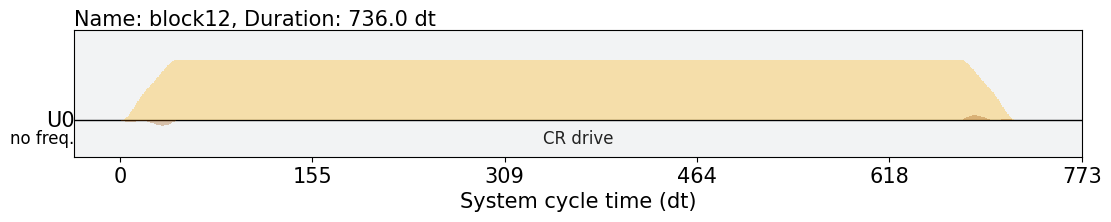

In [7]:
# Operating qubits
QUBIT_C, QUBIT_T = (0, 1)
# Compute the sampling time steps for the CR tomography experiments
if backend.name == 'DynamicsBackend':
    amp = 2 * pi * 0.04
    cr_times = np.arange(16*16, 1440*3, 32*4, dtype=int)
    duration = 720  # Used for plotting only, not tomography.
else:
    amp = get_default_cr_params(backend, QUBIT_C, QUBIT_T)[0]
    duration = backend.defaults().instruction_schedule_map.get("cx", (QUBIT_C, QUBIT_T)).duration/16 * 4
    cr_times = 16 * np.arange(16, duration + 16, duration//30, dtype=int)


## Custom shape
gate_name = "CR-recursive-tr10"
params = {
    "order": "3",  # order m for the initial pulse shape, order 1 is the Hann shape
    "t_r": 10,
    "drag_type" : "exact",  # Givens rotation, use "sw" for perturbation
    "duration": duration,  # only for plotting
    "amp": amp,
    "angle": 0.0,
    ## If real device, use the following
    # "Delta": (backend.properties().frequency(QUBIT_C) - backend.properties().frequency(QUBIT_T)) * 1.0e-9 * 2 * pi,
    # "a1": 2 * pi * backend.properties().qubit_property(QUBIT_C)["anharmonicity"][0] * 1.0e-9,
    ## If Dynamicsbackend, use this
    "Delta": 2 * pi * (f0 - f1) * 1.0e-9,
    "a1": 2 * pi * a0 * 1.0e-9,
    "drag_scale": [1., 1., 1.],
}
cr_params = params.copy()
ix_params = params.copy()
ix_params["amp"] = 0.0
ix_params["order"] = "2"

initial_calibration_data = {
    "cr_params": cr_params,
    "ix_params": ix_params,
    "frequency_offset": 0.,
}
get_cr_schedule((QUBIT_C, QUBIT_T), backend, cr_params=cr_params, ix_params=ix_params).draw()

2024-01-10 23:31:10,547, MainThread 
INFO 

CR calibration round 1: 
2024-01-10 23:31:32,925, MainThread 
INFO Tomography circuits have been generated.
2024-01-10 23:32:52,136, MainThread 
INFO CR tomography: 9d5176e3-175b-4bdc-a4ca-dfc572f901ec
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.25132741228718347, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.0, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
x_gate_ix_params: None
frequency_offset: 0.0

2024-01-10 23:32:52,353, MainThread 
INFO Job saved to data/9d5176e3-175b-4bdc-a4ca-dfc572

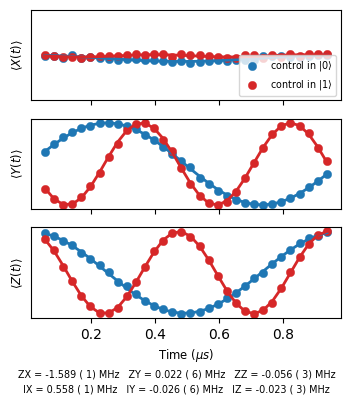

2024-01-10 23:32:52,789, MainThread 
INFO Tomography results:
{'IX': 0.5580533364751263, 'IY': -0.026484919309756785, 'IZ': -0.022672233015796198, 'ZX': -1.5889621958978808, 'ZY': 0.022468778113974987, 'ZZ': -0.05641368183413274}

2024-01-10 23:32:52,789, MainThread 
INFO Remaining dominant error: IX: 0.5580533364751263 MHz

2024-01-10 23:33:15,004, MainThread 
INFO Tomography circuits have been generated.
2024-01-10 23:34:34,349, MainThread 
INFO CR tomography: cf2d89eb-041e-4e11-b33f-13625c5c3bfb
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.25132741228718347, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': 'exact', 'durati

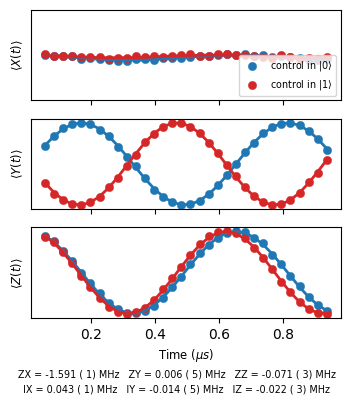

2024-01-10 23:34:35,012, MainThread 
INFO {'IX': 0.04290970447725583, 'IY': -0.014194651870517824, 'IZ': -0.022475690898049697, 'ZX': -1.5905762315630203, 'ZY': 0.006285064926171818, 'ZZ': -0.07148501070600713}
2024-01-10 23:34:35,013, MainThread 
INFO Frequency offset is updated to -22672.2330157962 Hz
2024-01-10 23:34:35,014, MainThread 
INFO 

CR calibration round 2: 
2024-01-10 23:34:58,315, MainThread 
INFO Tomography circuits have been generated.
2024-01-10 23:36:17,312, MainThread 
INFO CR tomography: 82dbb3dd-eb37-4d70-91e9-d55f703967e0
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.25132741228718347, 'angle': -0.014139594240687649, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
i

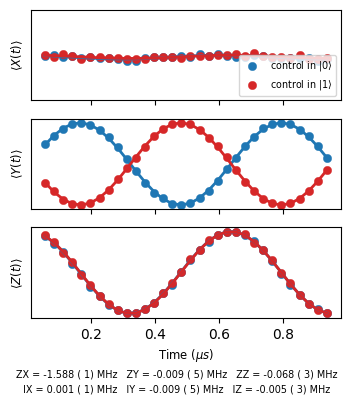

2024-01-10 23:36:18,020, MainThread 
INFO Tomography results:
{'IX': 0.0012476349489554896, 'IY': -0.008916357218343869, 'IZ': -0.00474984727336868, 'ZX': -1.5881762362150738, 'ZY': -0.008785067809121912, 'ZZ': -0.06769287693210214}

2024-01-10 23:36:18,021, MainThread 
INFO Remaining dominant error: IY: 0.008916357218343869 MHz

2024-01-10 23:36:18,021, MainThread 
INFO Successfully calibrated.


In [8]:
iterative_cr_pulse_calibration(
    (QUBIT_C, QUBIT_T),
    backend,
    initial_calibration_data=initial_calibration_data,
    cr_times=cr_times,
    session=session,
    gate_name=gate_name,
    verbose=True,
    restart=True,  # fresh start
    max_repeat=3,
    shots=2048,
    mode="CR",
    )

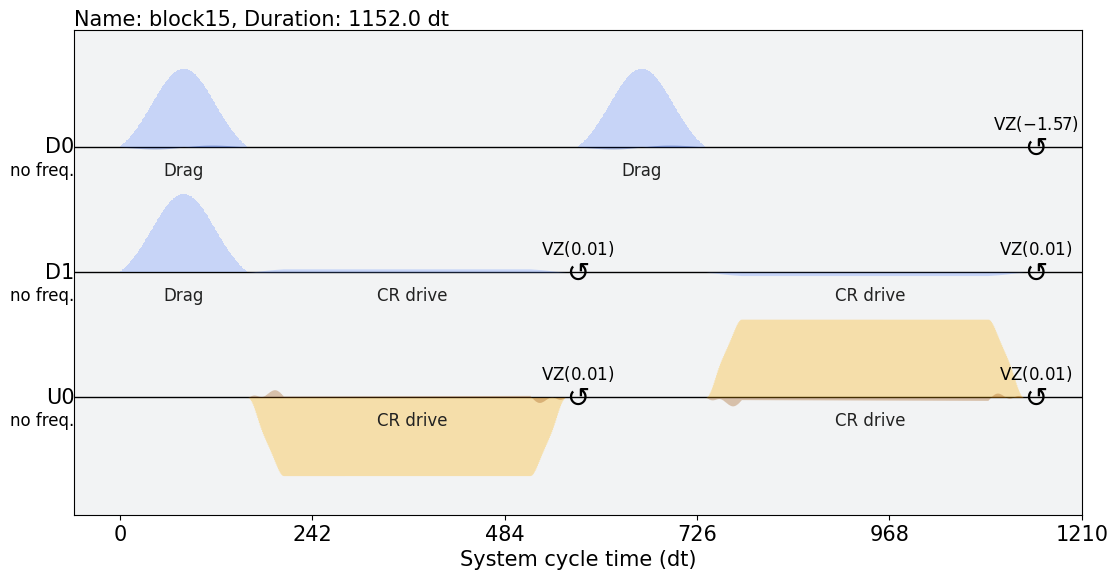

In [9]:
from qiskit_experiments.library import ProcessTomography
calibration_data = read_calibration_data(backend, gate_name, (QUBIT_C, QUBIT_T))

custom_cnot_sched = create_echoed_cnot_schedule(backend, (QUBIT_C, QUBIT_T), calibration_data, reverse_direction=False)

# Show the custom CNOT schedule.
custom_cnot_sched.draw()

2024-01-10 23:37:04,029, MainThread 
INFO Quantum process tomography job: bcd6de8e-e7e7-41c4-97ea-938360f6b3b0
backend: DynamicsBackend
qubits: (0, 1)
shots: 8096

2024-01-10 23:37:04,307, MainThread 
INFO Job saved to data/bcd6de8e-e7e7-41c4-97ea-938360f6b3b0



(<Figure size 800x600 with 2 Axes>,
 <Axes3D: title={'center': 'Process Matrix'}>)

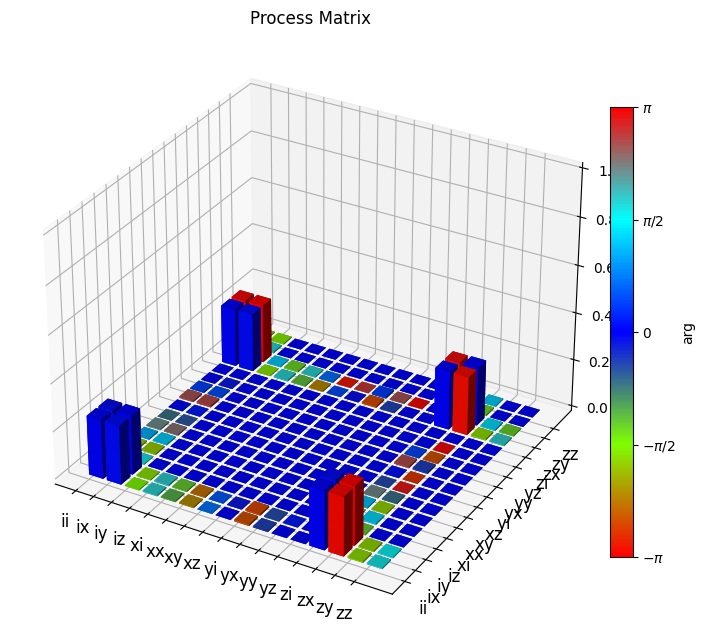

In [10]:
custom_cnot = Gate("custom_cnot", 2, [])
backend_tmp = deepcopy(backend)
backend_tmp.target.add_instruction(
    custom_cnot,
    {(QUBIT_C, QUBIT_T): InstructionProperties(calibration=custom_cnot_sched)},
    name="custom_cnot",
)
qptexp = ProcessTomography(custom_cnot, physical_qubits=[QUBIT_C, QUBIT_T])

try:
    basis_gates = backend.configuration().basis_gates
except AttributeError:
    basis_gates = ["measure", "sx", "x", "rz"]
transpiled_circ_list = transpile(
    qptexp._transpiled_circuits(),
    backend=backend_tmp,
    basis_gates = basis_gates + ["custom_cnot"],
    optimization_level= 1,  # Turn off optimization to keep the custom pulse
    )

shots = 8096
if session is not None:
    qpt_job = session.run(
        "circuit-runner",
        inputs={
            "circuits": transpiled_circ_list,
            "skip_transpilation": True,
            "shots": shots,
        },
    )
else:
    qpt_job = backend.run(transpiled_circ_list, shots=shots)

parameters = {
    "backend": backend.name,
    "qubits": (QUBIT_C, QUBIT_T),
    "shots": shots,
    }
logger.info(
    "Quantum process tomography job: "+
    str(qpt_job.job_id()) + "\n"
    + "\n".join([f"{key}: {val}" for key, val in parameters.items()])
    + "\n"
    )

save_job_data(qpt_job, backend=backend, exp=qptexp, parameters=parameters)

import qutip
qptdata = retrive_expdata(qpt_job, backend=backend)

state_result = qptdata.analysis_results("state")
choi_matrix = state_result.value.data
choi_qobj = qutip.Qobj(
    choi_matrix, dims=[[[2, 2], [2, 2]], [[2, 2], [2, 2]]], superrep="choi"
)
choi_qobj = choi_qobj.permute([[1, 0], [3, 2]])  # Permute the two qubit
qutip.choi_to_super(choi_qobj)
op_basis = [[qutip.qeye(2), qutip.sigmax(), qutip.sigmay(), qutip.sigmaz()]] * 2
chi_qobj = qutip.qpt(qutip.choi_to_super(choi_qobj), op_basis)
qutip.qpt_plot_combined(
    chi_qobj, lbls_list=[["i", "x", "y", "z"]] * 2, title="Process Matrix"
)

## Calibration of the IY DRAG to suppress ZZ error
We Calibrate the IY-DRAG amplitude to suppress the ZZ error. We first perform three experiments with different beta parameters and then perform a linear fit.
- If the default Gaussian pulse is used, refer to the qiskit DRAG pulse for the definition of beta.
- If the custom DRAG pulse is used, `beta` refers to the constant scaling coefficient for the DRAG correction term.

2024-01-10 23:37:06,053, MainThread 
INFO 
Calibrating the IY-DRAG pulse for (0, 1)-CR-recursive-tr10.
2024-01-10 23:37:25,617, MainThread 
INFO Tomography circuits have been generated.
2024-01-10 23:38:43,838, MainThread 
INFO CR tomography: 533567e4-f338-4c34-a291-ea71dff2e38c
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.25132741228718347, 'angle': -0.014139594240687649, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': '01', 'duration': 720, 'amp': -0.0035076454328084035, 'angle': 0.009430879968357075, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0], 'beta': 0.0}
x_gate_ix_params: None
frequency_offse

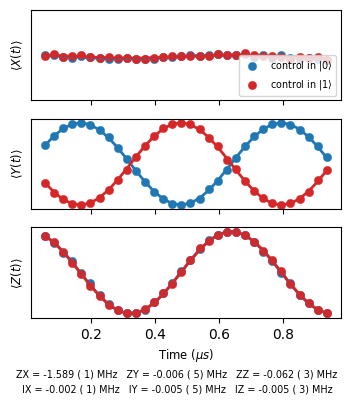

2024-01-10 23:39:04,137, MainThread 
INFO Tomography circuits have been generated.
2024-01-10 23:40:19,922, MainThread 
INFO CR tomography: af1731e1-ff05-46e9-9b42-6d7b3156d9a4
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 1024
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.25132741228718347, 'angle': -0.014139594240687649, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': '01', 'duration': 720, 'amp': -0.0035076454328084035, 'angle': 0.009430879968357075, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0], 'beta': -10.0}
x_gate_ix_params: None
frequency_offset: -22672.2330157962

2024-01-10 23:40:20,156, MainThread 
INFO Job saved to data/af1731e1-ff05-46e9-

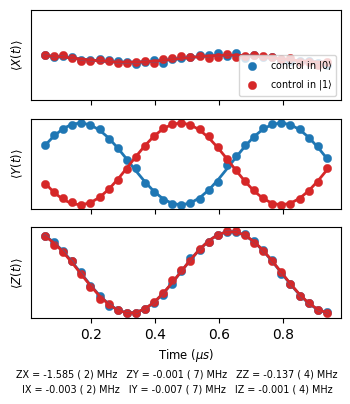

2024-01-10 23:40:40,225, MainThread 
INFO Tomography circuits have been generated.
2024-01-10 23:41:56,897, MainThread 
INFO CR tomography: 25c13727-8065-4fdb-8ca7-bea29e624271
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 1024
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.25132741228718347, 'angle': -0.014139594240687649, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': '01', 'duration': 720, 'amp': -0.0035076454328084035, 'angle': 0.009430879968357075, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0], 'beta': 10.0}
x_gate_ix_params: None
frequency_offset: -22672.2330157962

2024-01-10 23:41:57,123, MainThread 
INFO Job saved to data/25c13727-8065-4fdb-8

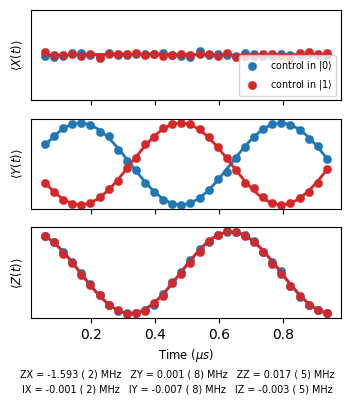

2024-01-10 23:41:57,682, MainThread 
INFO ZZ sampling measurements complete : [-0.062314198389442084, -0.1367360204455266, 0.016937724165898307].

2024-01-10 23:41:57,683, MainThread 
INFO Calibrated IY beta: 7.900395095154024



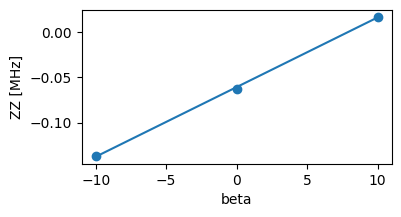

2024-01-10 23:42:16,289, MainThread 
INFO Tomography circuits have been generated.
2024-01-10 23:43:31,109, MainThread 
INFO CR tomography: 31793f5b-90eb-4cfa-8d96-573535d22789
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 720, 'amp': 0.25132741228718347, 'angle': -0.014139594240687649, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': '01', 'duration': 720, 'amp': -0.0035076454328084035, 'angle': 0.009430879968357075, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0], 'beta': 7.900395095154024}
x_gate_ix_params: None
frequency_offset: -22672.2330157962

2024-01-10 23:43:31,341, MainThread 
INFO Job saved to data/31793f5

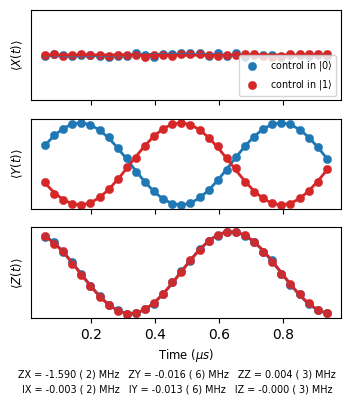

2024-01-10 23:43:31,776, MainThread 
INFO Updated coupling strength: {'IX': -0.002950216969652124, 'IY': -0.01309147522172804, 'IZ': -8.209312691477212e-05, 'ZX': -1.5904728197349023, 'ZY': -0.01588307827301502, 'ZZ': 0.003984765822202811}
2024-01-10 23:43:31,777, MainThread 
INFO IY-DRAG calibration complete, new calibration data saved.


In [11]:
iy_drag_calibration((QUBIT_C, QUBIT_T), backend, gate_name, cr_times, session, verbose=True, delta_beta=10.)

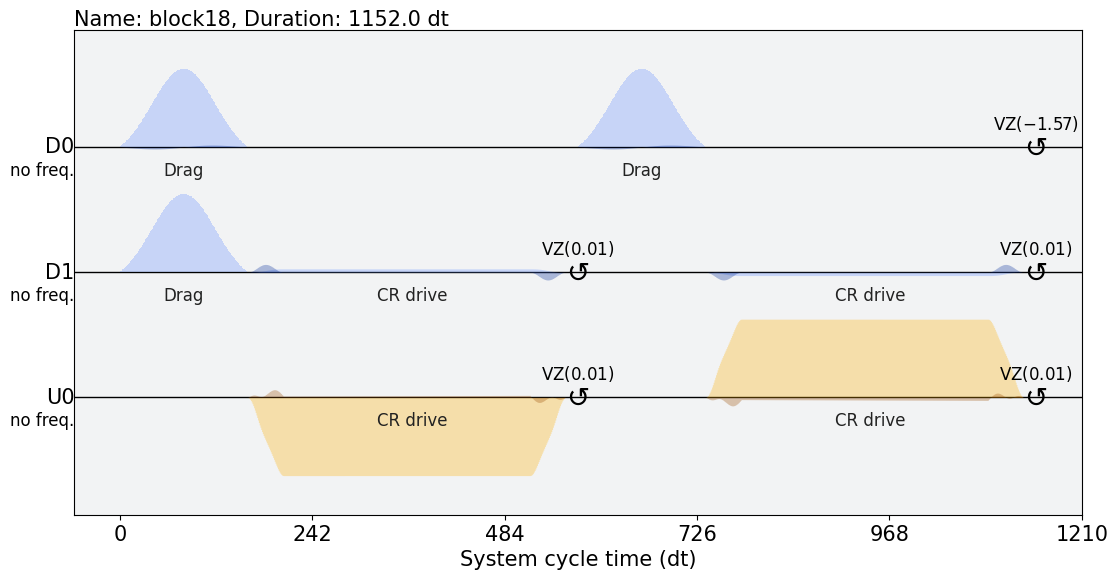

In [12]:
calibration_data = read_calibration_data(backend, gate_name, (QUBIT_C, QUBIT_T))

custom_cnot_sched = create_echoed_cnot_schedule(backend, (QUBIT_C, QUBIT_T), calibration_data, reverse_direction=False)

# Show the custom CNOT schedule.
custom_cnot_sched.draw()